In [ ]:
import seaborn as sns
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pdoc
import os
#import scipy
#import torch


def get_category_images(category_path):
    """
    Obtiene la lista de imágenes de una categoría específica.

    Parameters
    ----------
    category_path : str or Path
        Ruta a la carpeta de la categoría.

    Returns
    -------
    list of str
        Lista con los nombres de archivos de imágenes válidas 
        (.jpg, .jpeg, .png, .bmp, .gif) en la carpeta.
    """
    imagenes = [f for f in os.listdir(category_path)
                if os.path.isfile(os.path.join(category_path, f))
                and f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp', '.gif'))]
    return imagenes

def get_category_names(data_dir):
    """
    Lee los nombres de las categorías desde un archivo de texto.

    Parameters
    ----------
    data_dir : Path
        Ruta al directorio que contiene el archivo 'name of the animals.txt'.

    Returns
    -------
    list of str
        Lista con los nombres de las categorías (una por línea en el archivo).
    """
    path_names_category = data_dir / 'name of the animals.txt'
    with open(path_names_category, 'r') as f:
        category_names = [line.strip() for line in f if line.strip()]
    return category_names

def calculate_rgb_averages(data_dir):
    """
    Calcula los valores promedio de R, G y B por categoría de imágenes.

    Parameters
    ----------
    data_dir : Path
        Ruta al directorio de datos que contiene las imágenes dentro de 'mini_animals'.

    Returns
    -------
    dict
        Diccionario con las categorías como claves y los promedios [R, G, B] como valores.
    """
    category_names = get_category_names(data_dir)
    animals_dir = data_dir / 'mini_animals'
    # Diccionario para guardar la media por clase
    medias_rgb = {}
    for animal in category_names:
        imagenes = get_category_images(animals_dir / animal)
        # Listas para acumular valores por canal
        canales = []
        #Accedemos a la carpeta de la categoria
        carpeta_categoria = os.path.join(animals_dir, animal)
    
        for img_path in imagenes:
            ruta_foto = os.path.join(carpeta_categoria, img_path)
    
            img = Image.open(ruta_foto).convert("RGB")   # asegurar RGB
            arr = np.array(img, dtype=np.float32)
    
            # Calcular media por canal
            r_mean = arr[:, :, 0].mean()
            g_mean = arr[:, :, 1].mean()
            b_mean = arr[:, :, 2].mean()
            canales.append([r_mean, g_mean, b_mean])
    
        # Promedio total de la clase
        if canales:
            medias_rgb[animal] = np.mean(canales, axis=0)
    return medias_rgb

def plot_rgb_heatmap(df, path):
    """
    Genera un mapa de calor (heatmap) de valores promedio R, G, B por clase.

    Parameters
    ----------
    df : pandas.DataFrame
        DataFrame con columnas ['R', 'G', 'B', 'luminance'].
    path : Path
        Ruta donde se guardará la figura.
    """
    # Ordenar df_norm completo por luminancia
    df_sorted = df.sort_values('luminance')
    
    # Ahora pasamos solo R, G, B al heatmap
    plt.figure(figsize=(6, 12))
    sns.heatmap(df_sorted[['R','G','B']], annot=False, cmap='viridis')
    plt.title('Heatmap: R/G/B por clase (ordenadas por luminancia)')
    plt.xlabel('Canal')
    plt.ylabel('Clase (ordenada)')
    plt.tight_layout()
    plt.savefig(path / "heatmap_by_class.png")
    plt.show()

def plot_clustermap(df, path):
    """
    Genera un clustermap jerárquico de los valores R, G y B.

    Parameters
    ----------
    df : pandas.DataFrame
        DataFrame con columnas ['R', 'G', 'B'] normalizadas.
    path : Path
        Ruta donde se guardará la figura.
    """
    sns.clustermap(
        df_norm[['R','G','B']], 
        method='ward', metric='euclidean', 
        cmap='viridis', figsize=(8,12)
    )
    plt.suptitle('Clustermap de R/G/B (agrupamiento jerárquico)')
    plt.savefig(path / "clustermap_rgb.png")
    plt.show()

def plot_avg_colors(df, path):
    """
    Genera una visualización de los colores promedio por clase.

    Parameters
    ----------
    df : pandas.DataFrame
        DataFrame con columnas ['class', 'R', 'G', 'B'].
    path : Path
        Ruta donde se guardará la figura.
    """
    fig, axes = plt.subplots(nrows=15, ncols=6, figsize=(10, 20))  # ajustar rows/cols
    axes = axes.flatten()
    for ax_i, (cls, row) in zip(axes, df.iterrows()):
        ax_i.axis('off')
        ax_i.set_title(cls, fontsize=6)
        ax_i.add_patch(plt.Rectangle((0,0),1,1, color=row[['R','G','B']]/255.0))
    plt.tight_layout()
    plt.savefig(path / "color_averages.png")
    plt.show()

def get_df_with_rgb_avg(medias_rgb):
    """
    Convierte un diccionario de promedios RGB en un DataFrame y añade métricas adicionales.

    Parameters
    ----------
    medias_rgb : dict
        Diccionario con categorías como claves y valores [R, G, B] promedios.

    Returns
    -------
    pandas.DataFrame
        DataFrame con columnas:
        - 'class': nombre de la clase.
        - 'R', 'G', 'B': valores normalizados (0-1).
        - 'luminance': luminancia perceptual.
        - 'colorfulness': medida de colorfulness aproximada.
    """
    df = pd.DataFrame.from_dict(medias_rgb, orient='index', columns=['R','G','B'])
    df.index.name = 'class'
    
    # Pasar 'class' del índice a columna
    df = df.reset_index()
    
    print(df.head())
    print(df.columns)
    df_norm = df.copy()
    df_norm[['R','G','B']] = df[['R','G','B']] / 255.0
    
    # Calcular luminancia aproximada (perceptual)
    df_norm['luminance'] = 0.2126*df_norm['R'] + 0.7152*df_norm['G'] + 0.0722*df_norm['B']
    # Colorfulness (Hasler & Süsstrunk) — aproximación con R-G y Y-B
    rg = df_norm['R'] - df_norm['G']
    yb = 0.5*(df_norm['R'] + df_norm['G']) - df_norm['B']
    df_norm['colorfulness'] = np.sqrt(rg**2 + yb**2) + 0.3 * np.sqrt(rg.var() + yb.var())
    # Guardar para uso futuro
    df_norm.to_csv('medias_rgb_por_clase.csv')
    return df_norm


from pathlib import Path

if __name__ == '__main__':
    project_dir = Path.cwd().parent
    plots_dir = project_dir / 'reports' / 'figures'
    data_dir = project_dir / 'data'
    rgb_averages = calculate_rgb_averages(data_dir)
    df_norm = get_df_with_rgb_avg(rgb_averages)
    plot_rgb_heatmap(df_norm, plots_dir)
    plot_clustermap(df_norm, plots_dir)
    plot_avg_colors(df_norm, plots_dir)

In [6]:


print(Path(os.getcwd()))

C:\Users\Rober\Documents\Máster ML\Software Development applied to ML\git-animal-classification\notebooks


In [8]:
import os
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    classification_report
)
from sklearn.calibration import calibration_curve

predictions_dir = Path(os.getcwd()) / "predictions" ### fix folder structure

# --- Load saved predictions ---
val_probs = np.load(predictions_dir / "val_probs.npy")
val_labels = np.load(predictions_dir / "val_labels.npy")

print("Loaded arrays:")
print("val_probs:", val_probs.shape)
print("val_labels:", val_labels.shape)

# --- Basic predictions & accuracy ---
preds = val_probs.argmax(axis=1)
acc = accuracy_score(val_labels, preds)
print(f"Validation Accuracy: {acc:.4f}")


Loaded arrays:
val_probs: (360, 90)
val_labels: (360,)
Validation Accuracy: 0.7417


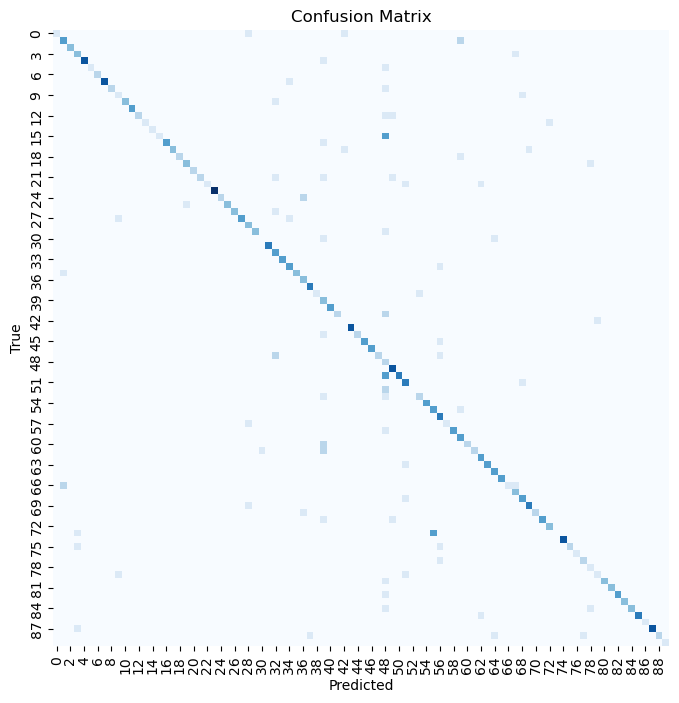

In [9]:
cm = confusion_matrix(val_labels, preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, cmap="Blues", square=True, cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


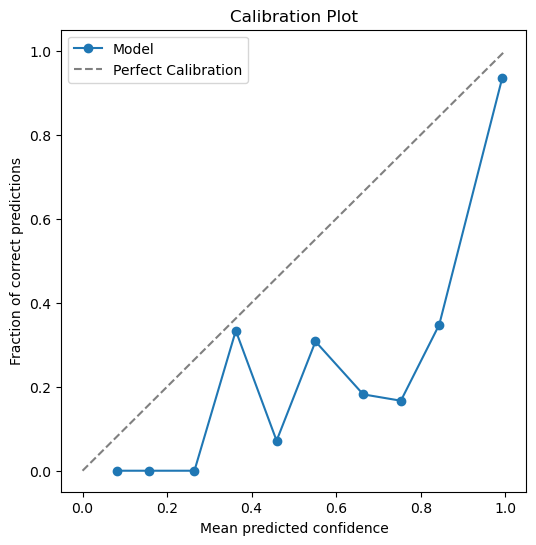

In [12]:
confidences = val_probs.max(axis=1)
correct = (preds == val_labels).astype(int)
frac_pos, mean_conf = calibration_curve(correct, confidences, n_bins=10)

plt.figure(figsize=(6,6))
plt.plot(mean_conf, frac_pos, marker='o', label='Model')
plt.plot([0,1], [0,1], '--', color='gray', label='Perfect Calibration')
plt.xlabel("Mean predicted confidence")
plt.ylabel("Fraction of correct predictions")
plt.title("Calibration Plot")
plt.legend()
plt.savefig("calibration_plot.png")
plt.show()


The model is overconfident. Its accuracy is much lower than its confidence. Only when the model's confidence is close to 100% does the accuracy get close to being aligned

In [11]:
from sklearn.metrics import precision_recall_fscore_support

prec, rec, f1, _ = precision_recall_fscore_support(val_labels, preds, average=None)
for i, (p, r, f) in enumerate(zip(prec, rec, f1)):
    print(f"Class {i}: precision={p:.3f}, recall={r:.3f}, f1={f:.3f}")


Class 0: precision=1.000, recall=0.333, f1=0.500
Class 1: precision=0.571, recall=0.667, f1=0.615
Class 2: precision=1.000, recall=1.000, f1=1.000
Class 3: precision=0.500, recall=0.750, f1=0.600
Class 4: precision=1.000, recall=0.857, f1=0.923
Class 5: precision=1.000, recall=0.500, f1=0.667
Class 6: precision=1.000, recall=1.000, f1=1.000
Class 7: precision=1.000, recall=0.857, f1=0.923
Class 8: precision=1.000, recall=0.667, f1=0.800
Class 9: precision=0.333, recall=0.500, f1=0.400
Class 10: precision=1.000, recall=0.750, f1=0.857
Class 11: precision=1.000, recall=1.000, f1=1.000
Class 12: precision=1.000, recall=0.500, f1=0.667
Class 13: precision=1.000, recall=0.500, f1=0.667
Class 14: precision=1.000, recall=1.000, f1=1.000
Class 15: precision=1.000, recall=0.200, f1=0.333
Class 16: precision=1.000, recall=0.800, f1=0.889
Class 17: precision=1.000, recall=0.600, f1=0.750
Class 18: precision=1.000, recall=0.667, f1=0.800
Class 19: precision=0.750, recall=0.750, f1=0.750
Class 20: 

C:\Users\Rober\miniconda3\envs\ufc\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Worst Classified Animals

In [16]:
from pathlib import Path

data_dir = Path("C:/Users/Rober/Documents/Máster ML/Software Development applied to ML/git-animal-classification/data/mini_animals")  # or whatever folder your data is in
# train_dir = data_dir / "train"  # adjust if needed
class_names = sorted([d.name for d in data_dir.iterdir() if d.is_dir()])
print(class_names)



['antelope', 'badger', 'bat', 'bear', 'bee', 'beetle', 'bison', 'boar', 'butterfly', 'cat', 'caterpillar', 'chimpanzee', 'cockroach', 'cow', 'coyote', 'crab', 'crow', 'deer', 'dog', 'dolphin', 'donkey', 'dragonfly', 'duck', 'eagle', 'elephant', 'flamingo', 'fly', 'fox', 'goat', 'goldfish', 'goose', 'gorilla', 'grasshopper', 'hamster', 'hare', 'hedgehog', 'hippopotamus', 'hornbill', 'horse', 'hummingbird', 'hyena', 'jellyfish', 'kangaroo', 'koala', 'ladybugs', 'leopard', 'lion', 'lizard', 'lobster', 'mosquito', 'moth', 'mouse', 'octopus', 'okapi', 'orangutan', 'otter', 'owl', 'ox', 'oyster', 'panda', 'parrot', 'pelecaniformes', 'penguin', 'pig', 'pigeon', 'porcupine', 'possum', 'raccoon', 'rat', 'reindeer', 'rhinoceros', 'sandpiper', 'seahorse', 'seal', 'shark', 'sheep', 'snake', 'sparrow', 'squid', 'squirrel', 'starfish', 'swan', 'tiger', 'turkey', 'turtle', 'whale', 'wolf', 'wombat', 'woodpecker', 'zebra']


In [35]:
import numpy as np
from sklearn.metrics import precision_recall_fscore_support

# Compute metrics per class
prec, rec, f1, _ = precision_recall_fscore_support(val_labels, preds, average=None, zero_division=0)

# Compute correct / total per class
classes = np.unique(val_labels)
class_counts = [(val_labels == c).sum() for c in classes]
correct_counts = [( (val_labels == c) & (preds == c) ).sum() for c in classes]
wrong_counts = [total - correct for total, correct in zip(class_counts, correct_counts)]

# Create a combined table
metrics = list(zip(classes, prec, rec, f1, correct_counts, wrong_counts, class_counts))

# Sort by F1 ascending
metrics_sorted = sorted(metrics, key=lambda x: x[3])

# --- Print results ---
print(f"{'Class':<20} {'Prec':<8} {'Rec':<8} {'F1':<8} {'Correct':<9} {'Wrong':<9} {'Total':<8}")
print("-" * 70)
for i, p, r, f, correct, wrong, total in metrics_sorted[:10]:  # show 10 worst
    class_name = class_names[i] if 'class_names' in locals() else f"Class {i}"
    print(f"{class_name:<20} {p:<8.3f} {r:<8.3f} {f:<8.3f} {correct:<9d} {wrong:<9d} {total:<8d}")


Class                Prec     Rec      F1       Correct   Wrong     Total   
----------------------------------------------------------------------
goose                0.000    0.000    0.000    0         2         2       
kangaroo             0.000    0.000    0.000    0         1         1       
octopus              0.000    0.000    0.000    0         2         2       
seal                 0.000    0.000    0.000    0         5         5       
lobster              0.087    1.000    0.160    2         0         2       
crab                 1.000    0.200    0.333    1         4         5       
hummingbird          0.214    1.000    0.353    3         0         3       
cat                  0.333    0.500    0.400    1         1         2       
possum               1.000    0.250    0.400    1         3         4       
squirrel             0.500    0.333    0.400    1         2         3       


In [50]:
print(class_names)

['antelope', 'badger', 'bat', 'bear', 'bee', 'beetle', 'bison', 'boar', 'butterfly', 'cat', 'caterpillar', 'chimpanzee', 'cockroach', 'cow', 'coyote', 'crab', 'crow', 'deer', 'dog', 'dolphin', 'donkey', 'dragonfly', 'duck', 'eagle', 'elephant', 'flamingo', 'fly', 'fox', 'goat', 'goldfish', 'goose', 'gorilla', 'grasshopper', 'hamster', 'hare', 'hedgehog', 'hippopotamus', 'hornbill', 'horse', 'hummingbird', 'hyena', 'jellyfish', 'kangaroo', 'koala', 'ladybugs', 'leopard', 'lion', 'lizard', 'lobster', 'mosquito', 'moth', 'mouse', 'octopus', 'okapi', 'orangutan', 'otter', 'owl', 'ox', 'oyster', 'panda', 'parrot', 'pelecaniformes', 'penguin', 'pig', 'pigeon', 'porcupine', 'possum', 'raccoon', 'rat', 'reindeer', 'rhinoceros', 'sandpiper', 'seahorse', 'seal', 'shark', 'sheep', 'snake', 'sparrow', 'squid', 'squirrel', 'starfish', 'swan', 'tiger', 'turkey', 'turtle', 'whale', 'wolf', 'wombat', 'woodpecker', 'zebra']


In [49]:
print(class_counts[class_names.get("squirrel")])

AttributeError: 'list' object has no attribute 'get'

In [26]:
print(metrics_sorted[5][3])

0.3333333333333333


**TRY TO CHECK THE EXACT VALIDATION PICTURES AND SEE WHAT THE MODEL PREDICTED ON EACH**

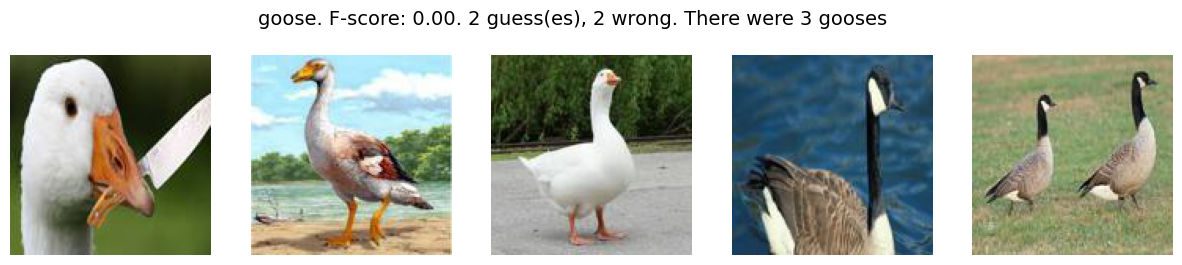

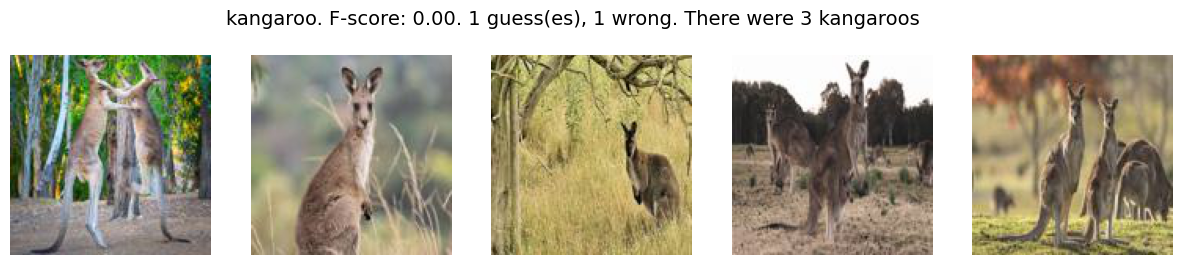

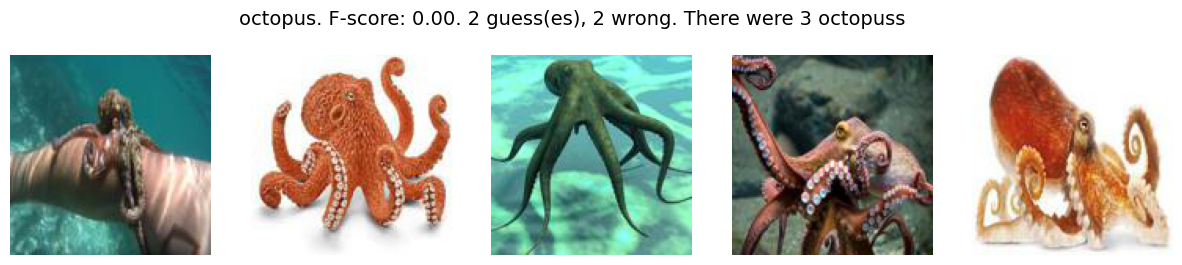

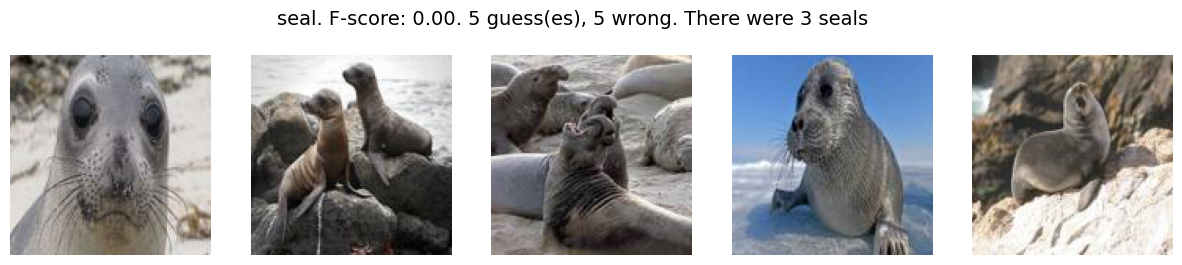

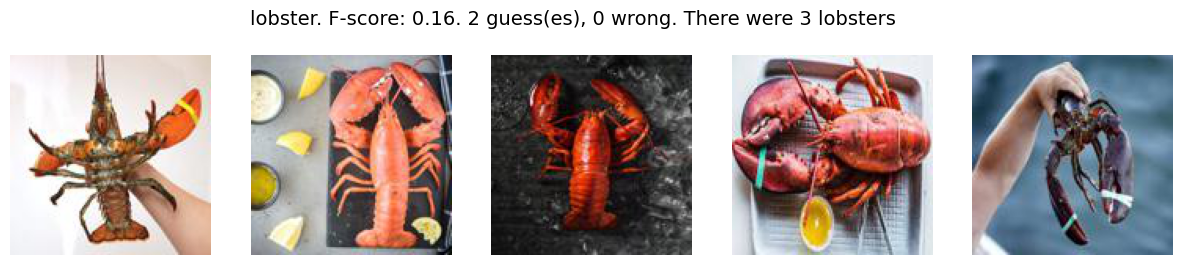

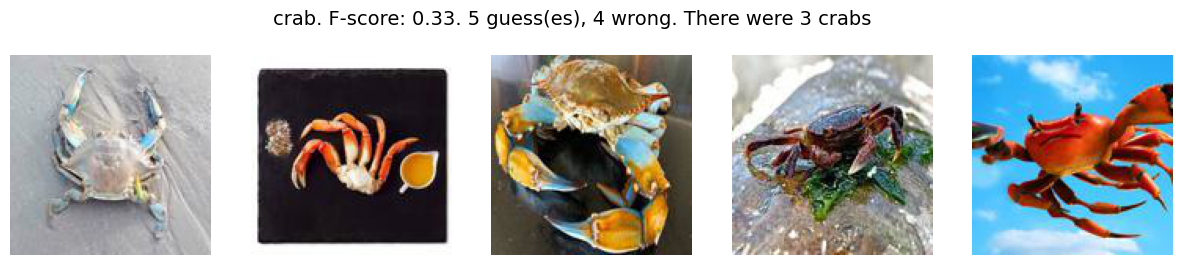

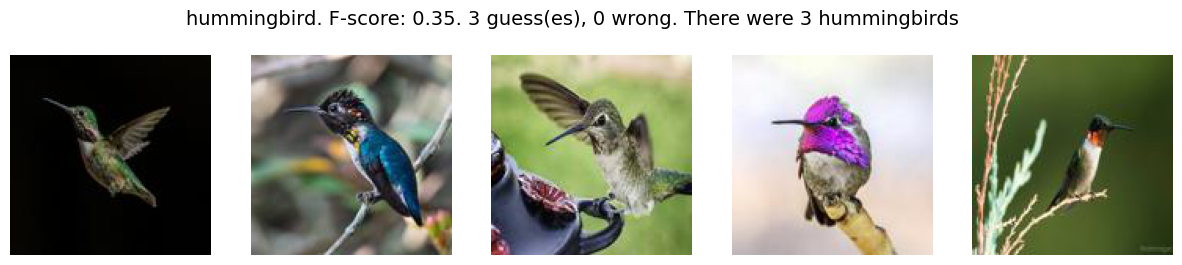

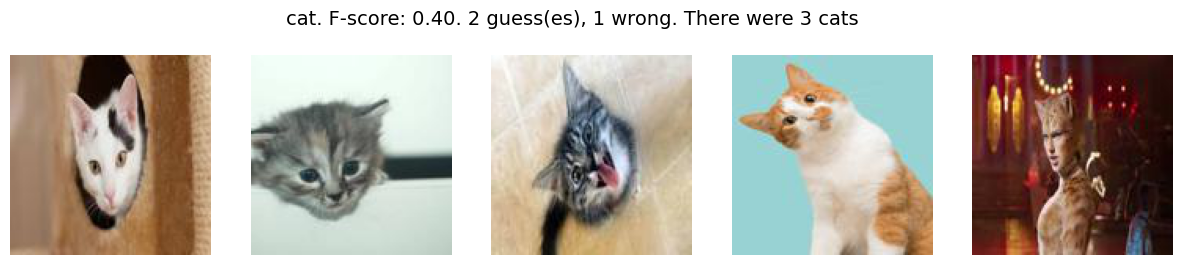

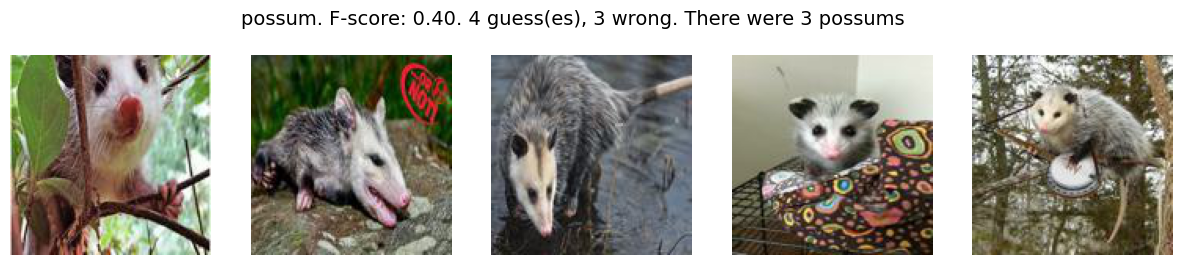

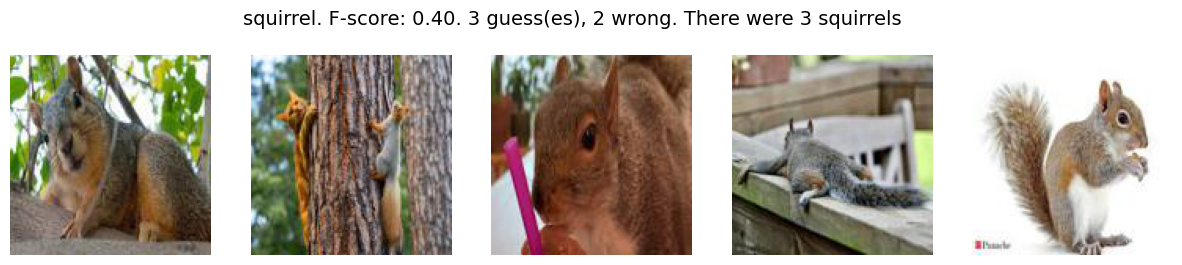

In [54]:
import matplotlib.pyplot as plt
import random
from pathlib import Path
from torchvision import datasets, transforms
from PIL import Image

# --- Settings ---  # adjust this to your validation folder
n_samples = 5  # how many images per class to show

# Simple transform for visualization
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

# Load validation dataset (same structure as during training)
val_dataset = datasets.ImageFolder(data_dir, transform=transform)

# Map class index to file paths
class_to_files = {}
for path, label in val_dataset.samples:
    class_to_files.setdefault(label, []).append(path)

# Show samples from the 5 worst F1 classes
worst_classes = [(i, f1, wrong, total) for i, _, _, f1, correct, wrong, total in metrics_sorted[:10]]

for (cls_idx, f1, wrong, total) in worst_classes:
    class_name = class_names[cls_idx] if 'class_names' in locals() else f"Class {cls_idx}"
    sample_paths = random.sample(class_to_files[cls_idx], min(n_samples, len(class_to_files[cls_idx])))

    fig, axes = plt.subplots(1, len(sample_paths), figsize=(15, 3))
    fig.suptitle(f"{class_name}. F-score: {f1:.2f}. {total} guess(es), {wrong} wrong. There were {class_counts[class_idx]} {class_name}s", fontsize=14)
    
    for ax, img_path in zip(axes, sample_paths):
        img = Image.open(img_path).convert("RGB")
        ax.imshow(img)
        ax.axis("off")
    
    plt.show()

In [44]:
print(worst_classes)

[(np.int64(30), np.float64(0.0), np.int64(0), np.int64(2)), (np.int64(42), np.float64(0.0), np.int64(0), np.int64(1)), (np.int64(52), np.float64(0.0), np.int64(0), np.int64(2)), (np.int64(73), np.float64(0.0), np.int64(0), np.int64(5)), (np.int64(48), np.float64(0.16), np.int64(2), np.int64(2)), (np.int64(15), np.float64(0.3333333333333333), np.int64(1), np.int64(5)), (np.int64(39), np.float64(0.35294117647058826), np.int64(3), np.int64(3)), (np.int64(9), np.float64(0.4), np.int64(1), np.int64(2)), (np.int64(66), np.float64(0.4), np.int64(1), np.int64(4)), (np.int64(79), np.float64(0.4), np.int64(1), np.int64(3))]
